# I. Preprocessing

### 0. Ensure datasets exist in `wustlcarla/datasets` directory

In [1]:
import os
DATASETS_DIRECTORY = '../datasets/'
try:
    if not os.listdir(DATASETS_DIRECTORY):
        print("No datasets found! Use `python3 notebooks/utils/get_sample_datasets.py` to download dataset!")
    else:
        print("Datasets exist")
except FileNotFoundError as e:
    print("Directory *{}* not found".format(DATASETS_DIRECTORY))
    raise e
except Exection as e:
    raise e

Datasets exist


### 0. Check if sufficient memory is available to load data

In [2]:
import psutil
memory = float(str(psutil.virtual_memory()).split('available=')[1].split(',')[0]) / 2 ** 30
min_memory = 30.0
print("Available Memory: {0:.2f} GB".format(memory))
print("Required Memory: {} GB".format(min_memory))
if memory <= min_memory:
    print("Insufficient memory. Please wait until more memory efficient pipeline is available to run the notebook.")
else:
    print("You have sufficient memory to run this notebook.")

Available Memory: 167.17 GB
Required Memory: 30.0 GB
You have sufficient memory to run this notebook.


### 1. Imports

In [3]:
import os                                 # system commands
import sys                                # system commands
import json                               # read measurement.json files
import torch                              # pytorch machine learning lib
import random                             # random lib
import numpy as np                        # numerical python lib
import torch.nn as nn                     # pytorch nueral network
from PIL import Image                     # image processing lib
import matplotlib.pyplot as plt           # plotting lib
from keras.utils import Progbar           # progress bar!
from timeit import default_timer as timer # time lib

Using TensorFlow backend.


### 2. Set up GPU

In [4]:
GPU_NUM = 0 #NUMBER BETWEEN 0 AND 7 INCLUSIVE
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(GPU_NUM)
current_device = torch.cuda.current_device()
device_count   = torch.cuda.device_count() - 1 #indexing starts at zero.
gpu_name       = torch.cuda.get_device_name(0)

print("This model will train on GPU {}/{}: {}".format(current_device, device_count, gpu_name))

This model will train on GPU 0/0: GeForce RTX 2080


### 3. Set Dataset directories

In [5]:
DATASET_DIR = '../datasets/'
TRAIN_DIR   = DATASET_DIR + 'CoILTrain'
VAL_DIR     = DATASET_DIR + 'CoILVal1'
TEST_DIR    = DATASET_DIR + 'CoILVal2'

### 4. Fetch episodes from Dataset directories

In [7]:
######## CHECK AVAILABLE DATA ########
use_default_directories = True

if use_default_directories:
    directories = [TRAIN_DIR, VAL_DIR, TEST_DIR]
else:
    directories = [TRAIN_DIR]
   
episode_list = []
for directory in directories:
    for item in os.listdir(directory):
        if 'episode' in item:
            episode_list.append(directory + '/' + item)

print("Total Episodes:", len(episode_list))
episode_list[:5]

Total Episodes: 42


['../datasets/CoILTrain/episode_00003',
 '../datasets/CoILTrain/episode_00018',
 '../datasets/CoILTrain/episode_00012',
 '../datasets/CoILTrain/episode_00000',
 '../datasets/CoILTrain/episode_00010']

### 5. Find Image and Measurement files

In [8]:
######## FIND IMAGE AND JSON DATA FILES ########
x_data_files       = []
y_data_files       = []
x_data_files_left  = []
x_data_files_right = []

central_camera_text = 'CentralRGB_'
left_camera_text    = 'LeftRGB_'
right_camera_text   = 'RightRGB_'
measurement_text    = 'measurements_'

for ep in episode_list:
    files = os.listdir(ep)
    for file in files:
        if central_camera_text in file:
            x_data_files.append(ep + '/' + file)
        if left_camera_text in file:
            x_data_files_left.append(ep + '/' + file)
        if right_camera_text in file:
            x_data_files_right.append(ep + '/' + file)
        if measurement_text in file:
            y_data_files.append(ep + '/' + file)
            
x_data_files       = sorted(x_data_files)
x_data_files_left  = sorted(x_data_files_left)
x_data_files_right = sorted(x_data_files_right)
y_data_files       = sorted(y_data_files)

print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

print("X_left length:", len(x_data_files_left), "| Sample:", x_data_files_left[0])
print("X_right length:", len(x_data_files_right), "| Sample:", x_data_files_right[0])

######## FIND AND FIX MISSING DATA ########
if len(x_data_files) != len(y_data_files):
    print("\nWarning: X and Y data files do not have the same length. Applying fix!")
    x = [''.join([i.split('episode_')[1].split('/')[0], 
              i.split('CentralRGB_')[1].split('.png')[0]]) for i in x_data_files]
    y = [''.join([i.split('episode_')[1].split('/')[0], 
                  i.split('measurements_')[1].split('.json')[0]]) for i in y_data_files]
    diff = list(set(y) - set(x))
    for item in diff:
        remove_ep  = '/wustlcarla/datasets/CoILTrain/episode_' + item[:5] + '/measurements_' + item[5:] + '.json'
        y_data_files.remove(remove_ep)
        print("Removed:", remove_ep)
    print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
    print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

X length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/CentralRGB_00000.png
Y length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/measurements_00000.json
X_left length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/LeftRGB_00000.png
X_right length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/RightRGB_00000.png


### 6. Load Image and Measurement Files

In [9]:
################## PROCESSING INPUT DATA ######################
FRAME_BATCH         = 6  # number of frames and respective data is clumped together
N                   = len(x_data_files) - len(x_data_files) % FRAME_BATCH # get rid of extra data that doesn't fit in batch

x_data_camera       = np.zeros((N, 88, 200, 3)).astype('uint8')
# x_data_camera_left  = np.zeros((N, 88, 200, 3)).astype('uint8')
# x_data_camera_right = np.zeros((N, 88, 200, 3)).astype('uint8')

x_data_speed        = np.zeros(N)
x_data_direction    = np.zeros(N)
    
y_steer             = np.zeros(N)
y_throttle          = np.zeros(N)
y_brake             = np.zeros(N)

stop_pedestrian     = np.zeros(N)
stop_traffic_lights = np.zeros(N)
stop_vehicle        = np.zeros(N)

pos_x               = np.zeros(N)
pos_y               = np.zeros(N)
pos_z               = np.zeros(N)

print("Extracting Center Camera images ...")
start   = timer()
progbar = Progbar(target=N, verbose=1)
for index, image in enumerate(x_data_files):
    if index < N:
        x_data_camera[index] = np.array(Image.open(image)).astype('uint8')
        progbar.update(index)
    else:
        break
end = timer()
print("\nExtracted Center Camera images (in {:.2f} seconds).".format(end-start))    

# print("Extracting Right Camera images ...")
# start   = timer()
# progbar = Progbar(target=N, verbose=1)
# for index, image in enumerate(x_data_files_right):
#     if index < N:
#         x_data_camera_right[index] = np.array(Image.open(image)).astype('uint8')
#         progbar.update(index)
#     else:
#         break
# end = timer()
# print("\nExtracted Right Camera images (in {:.2f} seconds).".format(end-start)) 

# print("Extracting Left Camera images ...")
# start   = timer()
# progbar = Progbar(target=N, verbose=1)
# for index, image in enumerate(x_data_files_left):
#     if index < N:
#         x_data_camera_left[index] = np.array(Image.open(image)).astype('uint8')
#         progbar.update(index)
#     else:
#         break
# end = timer()
# print("\nExtracted Left Camera images (in {:.2f} seconds).".format(end-start)) 

print("Extracting measurements ...")   
start   = timer()
progbar = Progbar(target=N, verbose=1)
for index, jsn in enumerate(y_data_files):
    if index < N:
        with open(jsn) as f:
            measurements = json.loads(f.read())
        x_data_direction[index] = measurements['directions']
        y_steer[index]          = measurements['steer']
        y_throttle[index]       = measurements['throttle']
        y_brake[index]          = measurements['brake']
        
        stop_pedestrian[index]     = measurements['stop_pedestrian']      
        stop_traffic_lights[index] = measurements['stop_traffic_lights'] 
        stop_vehicle[index]        = measurements['stop_vehicle'] 
        
        pos_x[index] = measurements['playerMeasurements']['transform']['location']['x']
        pos_y[index] = measurements['playerMeasurements']['transform']['location']['y']
        pos_z[index] = measurements['playerMeasurements']['transform']['location']['z']
        try:
            x_data_speed[index] = measurements['playerMeasurements']['forwardSpeed']        
        except:
            x_data_speed[index] = 0 # if forward speed not found, use speed = 0
        progbar.update(index)
    else:
        break 
y_data = np.array([y_steer, y_throttle, y_brake]).T
del y_steer, y_throttle, y_brake
end = timer()


print("\nExtracted measurements (in {:.2f} seconds).".format(end-start))    
print("X:", x_data_camera.shape, x_data_direction.shape, x_data_speed.shape)
print("Y (steer, throttle, brake):", y_data.shape)

Extracting Center Camera images ...
77064/77106 [============================>.] - ETA: 0s
Extracted Center Camera images (in 79.35 seconds).
Extracting measurements ...
77097/77106 [============================>.] - ETA: 0s
Extracted measurements (in 197.91 seconds).
X: (77106, 88, 200, 3) (77106,) (77106,)
Y (steer, throttle, brake): (77106, 3)


### Directions:
- 0 - void
- 2 - follow lane
- 3 - left
- 4 - right
- 5 - straight

### 7. Normalize speed & change void directions to lanefollow

In [10]:
############# CHANGE VOID DIRECTION TO LANE FOLLOW #############
x_data_direction[x_data_direction == 0] = 2

# ############# NORMALIZE SPEED #############
if np.max(x_data_speed) > 1:
    x_data_speed = x_data_speed / 12
else:
    print("Speeds may already been normalzied!")
x_data_speed[x_data_speed < 0] = 0
print("Speed (max, min)", max(x_data_speed), min(x_data_speed))

############# NORMALIZE STEER #############
# y_data[:, 0][y_data[:, 0] > 0.] = y_data[:, 0][y_data[:, 0] > 0.] / (np.max(y_data[:, 0]))
# y_data[:, 0][y_data[:, 0] < 0.] = y_data[:, 0][y_data[:, 0] < 0.] / (-np.min(y_data[:, 0]))
print("Steer (max, min)", max(y_data[:, 0]), min(y_data[:, 0]))

Speed (max, min) 0.8969029585520426 0.0
Steer (max, min) 0.6003490090370178 -0.3653394281864166


### Some visualizations of dataset

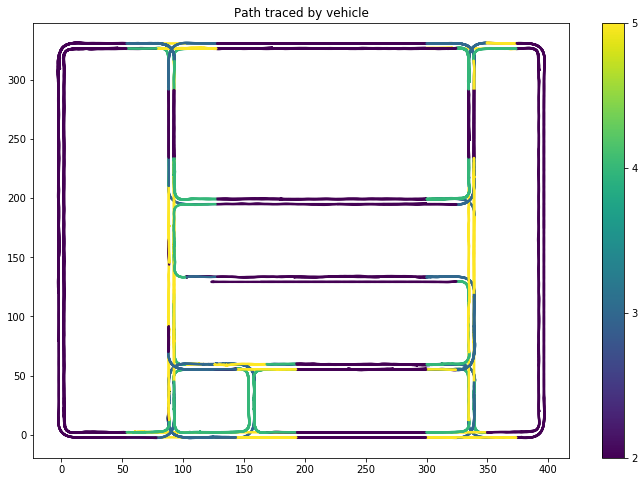

In [11]:
############# VISUALIZE VEHICLE PATH #############
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, cmap='viridis', s=2)
plt.title('Path traced by vehicle')
plt.colorbar(ticks=[2, 3, 4, 5])
plt.show()

Text(0.5,1,'Brake Histogram')

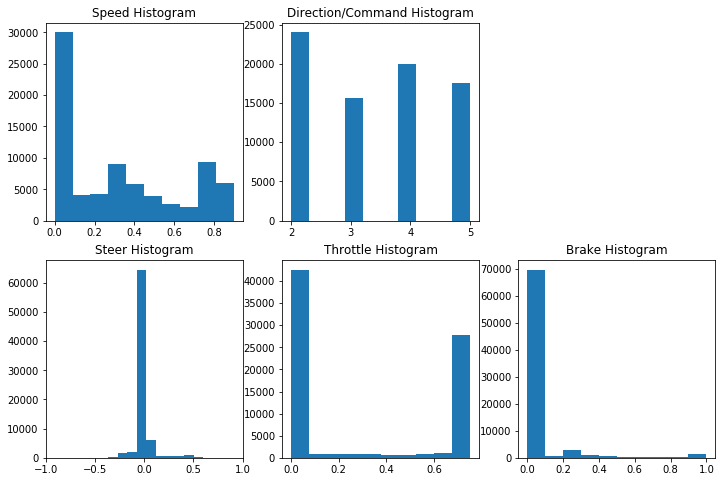

In [12]:
############# VISUALIZATION OF DATA DISTRIBUTION #############

fig, ax = plt.subplots(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.hist(x_data_speed, 10)
plt.title('Speed Histogram')

plt.subplot(2, 3, 2)
plt.hist(x_data_direction)
plt.title('Direction/Command Histogram')

plt.subplot(2, 3, 4)
plt.hist(y_data[:,0], 10)
plt.xlim([-1 ,1])
plt.title('Steer Histogram')

plt.subplot(2, 3, 5)
plt.hist(y_data[:,1], 10)
plt.title('Throttle Histogram')

plt.subplot(2, 3, 6)
plt.hist(y_data[:,2], 10)
plt.title('Brake Histogram')

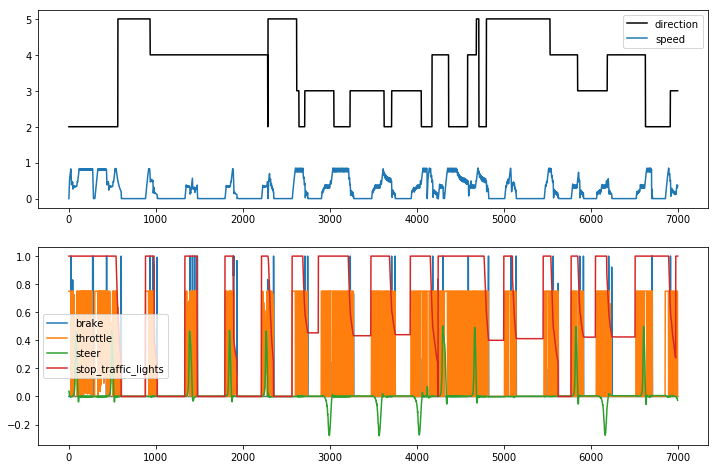

In [13]:
################## VISUALIZE CONTROL COMMANDS ######################
range_start, range_end = 0, 7000

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_data_direction[range_start:range_end], '-k', label='direction')
plt.plot(x_data_speed[range_start:range_end], label='speed')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_data[range_start:range_end,2], label='brake')
plt.plot(y_data[range_start:range_end,1], label='throttle')
plt.plot(y_data[range_start:range_end,0], label='steer')
# plt.plot(x_data_direction[range_start:range_end], '-k', label='direction') 
plt.plot(stop_traffic_lights[range_start:range_end], label='stop_traffic_lights')
plt.legend()

### 8. Filter data (remove red traffic light, and other options)

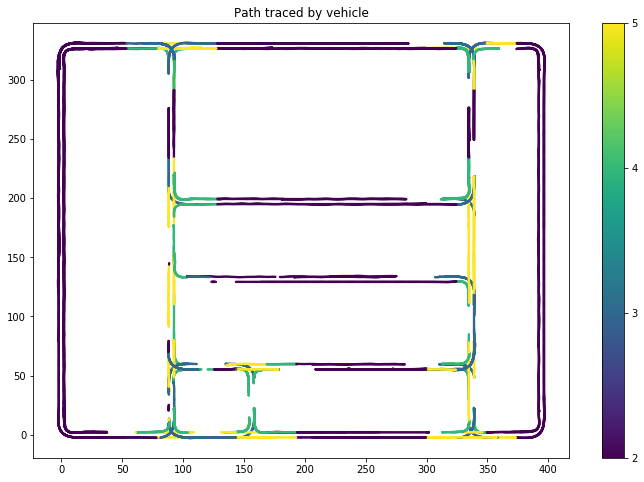

In [14]:
################## DATA PRUNING ######################
"""
- Remove hazards
"""
DIRECTION = None
# None - No direction filter
# 2 - follow lane
# 3 - left
# 4 - right
# 5 - straight

filters = {
    'red_traffic_light': stop_traffic_lights==1,
    'vehicle_ahead': stop_vehicle==1,
    'pedestrian_ahead': stop_pedestrian==1
}
lane_follow_filter = np.logical_and(filters['vehicle_ahead'], filters['red_traffic_light'])
lane_follow_filter = np.logical_and(lane_follow_filter, filters['pedestrian_ahead'])

if DIRECTION is not None:
    filters['direction'] = x_data_direction==DIRECTION
    lane_follow_filter = np.logical_and(lane_follow_filter, filters['direction'])

if len(lane_follow_filter) == len(x_data_camera):
    x_data_camera = x_data_camera[lane_follow_filter]
    # x_data_camera_left = x_data_camera_left[lane_follow_filter]
    # x_data_camera_right = x_data_camera_right[lane_follow_filter]
    x_data_speed = x_data_speed[lane_follow_filter]
    x_data_direction = x_data_direction[lane_follow_filter]
    y_data = y_data[lane_follow_filter]

    pos_x = pos_x[lane_follow_filter]
    pos_y = pos_y[lane_follow_filter]
    pos_z = pos_z[lane_follow_filter]

############# VISUALIZE VEHICLE PATH #############
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, cmap='viridis', s=2)
plt.title('Path traced by vehicle')
plt.colorbar(ticks=[2, 3, 4, 5])
plt.show()

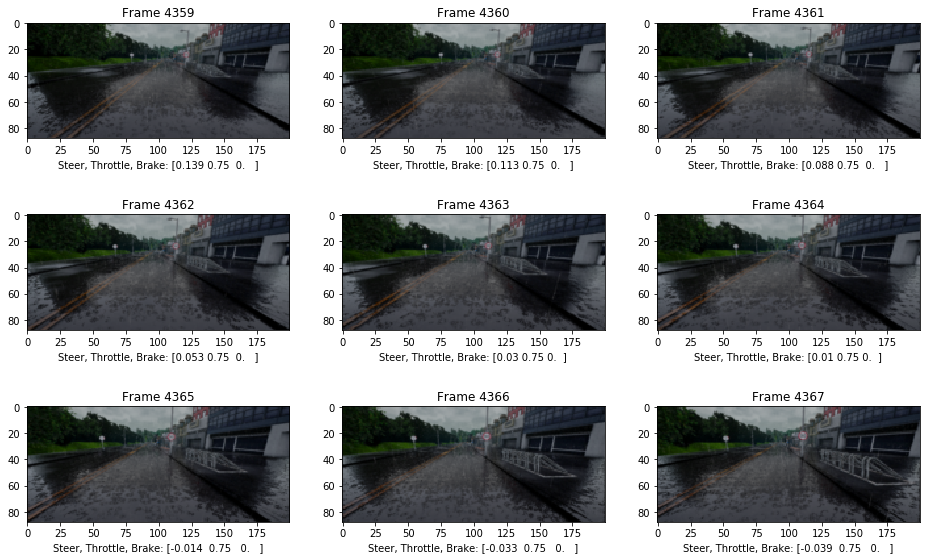

In [15]:
############# VISUALIZE SOME CAMERA FRAMES #############
fig, ax = plt.subplots(figsize=(16, 10))
sample = np.random.randint(len(x_data_camera)-10)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_data_camera[i+sample])
    plt.title("Frame " + str(i+sample))
    plt.xlabel("Steer, Throttle, Brake: "+ str(np.round(y_data[i+sample], 3)))

### 9. Split data into Train and Test sets

In [16]:
############# SPLIT DATA TO TRAINING AND TEST SETS #############
from sklearn.model_selection import ShuffleSplit, train_test_split

SPLIT_RATIO = 0.7
SHUFFLE = False

try:
    if not SHUFFLE:
        split = int(len(y_data) * SPLIT_RATIO)
        x_train_camera, x_test_camera = x_data_camera[:split], x_data_camera[split+1:]
        x_train_speed, x_test_speed = x_data_speed[:split], x_data_speed[split+1:]
        x_train_direction, x_test_direction = x_data_direction[:split], x_data_direction[split+1:]
        y_train, y_test = y_data[:split], y_data[split+1:]
    else:
        indices = np.arange(len(y_data))
        x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(indices, indices, test_size=(1-SPLIT_RATIO))
        
        x_train_camera, x_test_camera = x_data_camera[x_train_ind, :, :, 0:3], x_data_camera[x_test_ind, :, :, 0:3]
        x_train_speed, x_test_speed  = x_data_speed[x_train_ind], x_data_speed[x_test_ind]
        x_train_direction, x_test_direction = x_data_direction[x_train_ind], x_data_direction[x_test_ind]
        y_train, y_test = y_data[y_train_ind, :], y_data[y_test_ind, :]
        
        del indices, x_train_ind, x_test_ind, y_train_ind, y_test_ind
except Error as E:
    print(E)
    print("x_data_* and y_data values are empty. Using previously stored values.")
    
print("Train Shape | x_train_camera:", x_train_camera.shape, "\t| x_train_speed:", x_train_speed.shape,
      "\t| y_train:", y_train.shape)
print(" Test Shape | x_test_camera:", x_test_camera.shape, "\t| x_test_speed:", x_test_speed.shape, 
      "\t| y_test:", y_test.shape)

Train Shape | x_train_camera: (22394, 88, 200, 3) 	| x_train_speed: (22394,) 	| y_train: (22394, 3)
 Test Shape | x_test_camera: (9597, 88, 200, 3) 	| x_test_speed: (9597,) 	| y_test: (9597, 3)


### 10. Normalize Image data

In [17]:
############# PREPROCESS DATA #############
img_rows, img_cols, img_chnls = 88, 200, 3 # input image dimensions

if np.max(np.max(x_train_camera)) > 1:
    x_train_camera = x_train_camera.reshape(x_train_camera.shape[0], img_rows, img_cols, img_chnls)
    x_test_camera  = x_test_camera.reshape(x_test_camera.shape[0], img_rows, img_cols, img_chnls)
    x_train_camera = x_train_camera.astype('float32')
    x_test_camera = x_test_camera.astype('float32')
    x_train_camera /= 255
    x_test_camera /= 255
else:
    print("Images have already been normalized.")
    
print('x_train shape:', x_train_camera.shape)
print(x_train_camera.shape[0], 'train samples')
print(x_test_camera.shape[0], 'test samples')

x_train shape: (22394, 88, 200, 3)
22394 train samples
9597 test samples


# II. Training

### 11. Reshape camera data to fit PyTorch convolution format

tensor(1.) torch.Size([88, 200, 3])


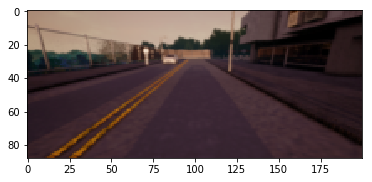

In [18]:
x_train_camera_2 = torch.from_numpy(x_train_camera).permute(0, 3, 1, 2)
x_test_camera_2 = torch.from_numpy(x_test_camera).permute(0, 3, 1, 2)

x_train_camera_2 = x_train_camera_2.type('torch.FloatTensor')
x_test_camera_2 = x_test_camera_2.type('torch.FloatTensor')

y_train_2 = torch.from_numpy(y_train).type('torch.FloatTensor')
y_test_2 = torch.from_numpy(y_test).type('torch.FloatTensor')

print(x_train_camera_2.max(), x_train_camera_2.permute(0, 2, 3, 1)[0].shape)
plt.imshow(x_train_camera_2.permute(0, 2, 3, 1)[0].cpu())

In [19]:
x_train_camera.shape, x_train_camera_2.shape

((22394, 88, 200, 3), torch.Size([22394, 3, 88, 200]))

### 12. Set up pytorch Network Architecture

In [97]:
class wustlcarla(nn.Module):
    def __init__(self, output_dim):
        super(wustlcarla, self).__init__()

        # input_dim = (3,88,200)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=4),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True))
            
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True))        

        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=256),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True)
        )
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=256),
            nn.Dropout2d(p=0.1),
            nn.ReLU(inplace=True)
        )
        
        self.fc1_speed = nn.Sequential(
                 nn.Linear(1, 128),
                 nn.Dropout(p=0.5),
                 nn.ReLU()
        )
        
        self.fc2_speed = nn.Sequential(
                 nn.Linear(128, 128),
                 nn.Dropout(p=0.5),
                 nn.ReLU()        
        )
          
        self.fc1 = nn.Sequential(
#             nn.Linear(67456, 512),
            nn.Linear(188160, 512),
            nn.Dropout(p=0.3),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features = 512, out_features=512),
            nn.Dropout(p=0.3),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features = 640, out_features=256),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )     
            
        # begin branching
        self.lanefollow = nn.Linear(in_features=256, out_features=256)
        self.right = nn.Linear(in_features=256, out_features=256)
        self.left = nn.Linear(in_features=256, out_features=256)
        self.straight = nn.Linear(in_features=256, out_features=256)
        
        self.fc4_lane = nn.Sequential(
            nn.Linear(in_features = 256, out_features=256),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )    
        self.fc5_lane = nn.Sequential(
            nn.Linear(in_features = 256, out_features=output_dim)
        ) 
        
        self.fc4_right = nn.Sequential(
            nn.Linear(in_features = 256, out_features=256),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )             
        self.fc5_right = nn.Sequential(
            nn.Linear(in_features = 256, out_features=output_dim)
        ) 
        
        self.fc4_left = nn.Sequential(
            nn.Linear(in_features = 256, out_features=256),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )           
        self.fc5_left = nn.Sequential(
            nn.Linear(in_features = 256, out_features=output_dim)
        ) 
        
        self.fc4_straight = nn.Sequential(
            nn.Linear(in_features = 256, out_features=256),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )    
        self.fc5_straight = nn.Sequential(
            nn.Linear(in_features = 256, out_features=output_dim)
        )         

       
    def forward(self, x=torch.zeros(1,88,200,3), speed=0, command=3):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        out_speed = self.fc1_speed(speed)
        out_speed = self.fc2_speed(out_speed)
        out = torch.cat([out, out_speed], 1)
        
        out = self.fc3(out)
        
        left     = self.left(out)
        left     = self.fc4_left(left)
        left     = self.fc5_left(left)
        
        right     = self.right(out)
        right     = self.fc4_right(right)
        right     = self.fc5_right(right)
        
        lane     = self.lanefollow(out)
        lane     = self.fc4_lane(lane)
        lane     = self.fc5_lane(lane)
        
        straight     = self.straight(out)
        straight     = self.fc4_straight(straight)
        straight     = self.fc5_straight(straight)
        
        out = torch.where(torch.eq(command, 2.0), lane,
                   (torch.where(torch.eq(command, 3.0), right, 
                   (torch.where(torch.eq(command, 4.0), left, straight)))))

        return out

### 13. Set up network and test one example (forward pass)

In [98]:
model = wustlcarla(output_dim=3)

In [99]:
image = x_train_camera_2[10:32]
speed = torch.from_numpy(x_train_speed[10:32]).type('torch.FloatTensor').reshape(-1,1)
direction = torch.from_numpy(x_train_direction[10:32]).type('torch.FloatTensor').reshape(-1,1)
image = image.type('torch.FloatTensor')
output = model.forward(image,speed,direction)
output

tensor([[-0.0207,  0.0408,  0.0062],
        [-0.0326, -0.0264,  0.0025],
        [ 0.0135,  0.0095, -0.0268],
        [ 0.0195,  0.0052,  0.0328],
        [-0.0598,  0.0322,  0.0235],
        [ 0.0075,  0.0277, -0.0111],
        [-0.0425,  0.0179,  0.0161],
        [ 0.0016,  0.0314, -0.0116],
        [ 0.0018, -0.0406, -0.0239],
        [-0.0322,  0.0212, -0.0204],
        [-0.0218, -0.0003, -0.0067],
        [ 0.0024,  0.0108, -0.0325],
        [-0.0324, -0.0114,  0.0242],
        [-0.0007,  0.0043, -0.0234],
        [-0.0310,  0.0097,  0.0025],
        [ 0.0044, -0.0365, -0.0428],
        [-0.0402, -0.0096,  0.0327],
        [-0.0323, -0.0535, -0.0381],
        [ 0.0018,  0.0001,  0.0035],
        [-0.0012,  0.0035, -0.0179],
        [-0.0532,  0.0316,  0.0421],
        [-0.0309, -0.0210,  0.0149]], grad_fn=<SWhereBackward>)

In [100]:
model = model.to(device)

### 14. Set up Hyper Parameters

In [102]:
learning_rate = 0.0001
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Set up data loaders

In [103]:
import torch.utils.data
# from torch.autograd import Variable
batch_size=120
test_batch_size=100
use_cuda=True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_indices = list(range(0, len(x_train_camera_2)))
train_loader = torch.utils.data.DataLoader(
    (train_indices),
    batch_size= batch_size, shuffle=True, **kwargs)

test_indices = list(range(0, len(x_test_camera_2)))
test_loader = torch.utils.data.DataLoader(
    (test_indices),
    batch_size= test_batch_size, shuffle=False, **kwargs)

In [104]:
def train(model, controls, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (indices) in enumerate(train_loader):
        data = x_train_camera_2[indices]
        target = controls[indices]
        curr_dir = x_train_direction_torch[indices].reshape(-1,1).cuda().to(device)
        curr_speed = x_train_speed_torch[indices].reshape(-1,1).to(device).cuda()
        data, target = data.to(device).cuda(), target.to(device).cuda()
        optimizer.zero_grad()
        output = model(data, curr_speed, curr_dir)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #print(list(net.parameters())[0].data.cpu().numpy())

In [105]:
def test(model, controls, device, test_loader):
    model.eval()
    test_loss = 0
    loss_history = []
    with torch.no_grad():
        for batch_idx, (indices) in enumerate(test_loader):
            data = x_test_camera_2[indices]
            target = controls[indices]
            curr_dir = x_test_direction_torch[indices].reshape(-1,1).cuda().to(device)
            curr_speed = x_test_speed_torch[indices].reshape(-1,1).cuda().to(device)
            data, target = data.to(device).cuda(), target.to(device).cuda()
            output = model(data, curr_speed, curr_dir)
            loss_history.append(criterion(output, target).item()) # sum up batch loss

    print('\nTest set: Average loss: {:.4f}\n'.format(np.mean(loss_history)))
    return np.mean(loss_history)

In [106]:
x_train_direction_torch = torch.from_numpy(x_train_direction).type("torch.FloatTensor")
x_train_speed_torch = torch.from_numpy(x_train_speed).type("torch.FloatTensor")
x_test_direction_torch = torch.from_numpy(x_test_direction).type("torch.FloatTensor")
x_test_speed_torch = torch.from_numpy(x_test_speed).type("torch.FloatTensor")

In [107]:
loss_history = []

In [224]:
# criterion = nn.L1Loss()
log_interval = 10
epochs = 200

# target_train = y_train_2[:, 0]
# target_test = y_test_2[:, 0].re

for epoch in range(1, epochs + 1):
    train(model, y_train_2, device, train_loader, optimizer, epoch)
    print("*"*50)
    loss_history.append(test(model, y_test_2, device, test_loader))

Train Epoch: 1 [0/22394 (0%)]	Loss: 0.016258
Train Epoch: 1 [1200/22394 (5%)]	Loss: 0.022062
Train Epoch: 1 [2400/22394 (11%)]	Loss: 0.017449
Train Epoch: 1 [3600/22394 (16%)]	Loss: 0.020277
Train Epoch: 1 [4800/22394 (21%)]	Loss: 0.020237
Train Epoch: 1 [6000/22394 (27%)]	Loss: 0.018949
Train Epoch: 1 [7200/22394 (32%)]	Loss: 0.017401
Train Epoch: 1 [8400/22394 (37%)]	Loss: 0.020209
Train Epoch: 1 [9600/22394 (43%)]	Loss: 0.019153
Train Epoch: 1 [10800/22394 (48%)]	Loss: 0.017782
Train Epoch: 1 [12000/22394 (53%)]	Loss: 0.018253
Train Epoch: 1 [13200/22394 (59%)]	Loss: 0.020926
Train Epoch: 1 [14400/22394 (64%)]	Loss: 0.020392
Train Epoch: 1 [15600/22394 (70%)]	Loss: 0.016472
Train Epoch: 1 [16800/22394 (75%)]	Loss: 0.024804
Train Epoch: 1 [18000/22394 (80%)]	Loss: 0.018568
Train Epoch: 1 [19200/22394 (86%)]	Loss: 0.017487
Train Epoch: 1 [20400/22394 (91%)]	Loss: 0.020494
Train Epoch: 1 [21600/22394 (96%)]	Loss: 0.017257
**************************************************

Test set: Av

Train Epoch: 9 [1200/22394 (5%)]	Loss: 0.016074
Train Epoch: 9 [2400/22394 (11%)]	Loss: 0.016873
Train Epoch: 9 [3600/22394 (16%)]	Loss: 0.024433
Train Epoch: 9 [4800/22394 (21%)]	Loss: 0.018254
Train Epoch: 9 [6000/22394 (27%)]	Loss: 0.021231
Train Epoch: 9 [7200/22394 (32%)]	Loss: 0.020373
Train Epoch: 9 [8400/22394 (37%)]	Loss: 0.019786
Train Epoch: 9 [9600/22394 (43%)]	Loss: 0.020445
Train Epoch: 9 [10800/22394 (48%)]	Loss: 0.019754
Train Epoch: 9 [12000/22394 (53%)]	Loss: 0.015911
Train Epoch: 9 [13200/22394 (59%)]	Loss: 0.022444
Train Epoch: 9 [14400/22394 (64%)]	Loss: 0.021935
Train Epoch: 9 [15600/22394 (70%)]	Loss: 0.015433
Train Epoch: 9 [16800/22394 (75%)]	Loss: 0.019165
Train Epoch: 9 [18000/22394 (80%)]	Loss: 0.019339
Train Epoch: 9 [19200/22394 (86%)]	Loss: 0.015828
Train Epoch: 9 [20400/22394 (91%)]	Loss: 0.021334
Train Epoch: 9 [21600/22394 (96%)]	Loss: 0.020182
**************************************************

Test set: Average loss: 0.0303

Train Epoch: 10 [0/22394 


Test set: Average loss: 0.0292

Train Epoch: 17 [0/22394 (0%)]	Loss: 0.021133
Train Epoch: 17 [1200/22394 (5%)]	Loss: 0.015493
Train Epoch: 17 [2400/22394 (11%)]	Loss: 0.021609
Train Epoch: 17 [3600/22394 (16%)]	Loss: 0.016629
Train Epoch: 17 [4800/22394 (21%)]	Loss: 0.019810
Train Epoch: 17 [6000/22394 (27%)]	Loss: 0.019982
Train Epoch: 17 [7200/22394 (32%)]	Loss: 0.018718
Train Epoch: 17 [8400/22394 (37%)]	Loss: 0.017851
Train Epoch: 17 [9600/22394 (43%)]	Loss: 0.020507
Train Epoch: 17 [10800/22394 (48%)]	Loss: 0.018200
Train Epoch: 17 [12000/22394 (53%)]	Loss: 0.021573
Train Epoch: 17 [13200/22394 (59%)]	Loss: 0.015518
Train Epoch: 17 [14400/22394 (64%)]	Loss: 0.019562
Train Epoch: 17 [15600/22394 (70%)]	Loss: 0.019591
Train Epoch: 17 [16800/22394 (75%)]	Loss: 0.019409
Train Epoch: 17 [18000/22394 (80%)]	Loss: 0.022506
Train Epoch: 17 [19200/22394 (86%)]	Loss: 0.020153
Train Epoch: 17 [20400/22394 (91%)]	Loss: 0.021500
Train Epoch: 17 [21600/22394 (96%)]	Loss: 0.021245
************

Train Epoch: 24 [21600/22394 (96%)]	Loss: 0.018922
**************************************************

Test set: Average loss: 0.0288

Train Epoch: 25 [0/22394 (0%)]	Loss: 0.021596
Train Epoch: 25 [1200/22394 (5%)]	Loss: 0.025518
Train Epoch: 25 [2400/22394 (11%)]	Loss: 0.019240
Train Epoch: 25 [3600/22394 (16%)]	Loss: 0.023402
Train Epoch: 25 [4800/22394 (21%)]	Loss: 0.019907
Train Epoch: 25 [6000/22394 (27%)]	Loss: 0.021058
Train Epoch: 25 [7200/22394 (32%)]	Loss: 0.020060
Train Epoch: 25 [8400/22394 (37%)]	Loss: 0.021983
Train Epoch: 25 [9600/22394 (43%)]	Loss: 0.017011
Train Epoch: 25 [10800/22394 (48%)]	Loss: 0.022694
Train Epoch: 25 [12000/22394 (53%)]	Loss: 0.021422
Train Epoch: 25 [13200/22394 (59%)]	Loss: 0.021512
Train Epoch: 25 [14400/22394 (64%)]	Loss: 0.020061
Train Epoch: 25 [15600/22394 (70%)]	Loss: 0.018846
Train Epoch: 25 [16800/22394 (75%)]	Loss: 0.020226
Train Epoch: 25 [18000/22394 (80%)]	Loss: 0.021328
Train Epoch: 25 [19200/22394 (86%)]	Loss: 0.025224
Train Epoch:

Train Epoch: 32 [19200/22394 (86%)]	Loss: 0.020725
Train Epoch: 32 [20400/22394 (91%)]	Loss: 0.019967
Train Epoch: 32 [21600/22394 (96%)]	Loss: 0.018182
**************************************************

Test set: Average loss: 0.0283

Train Epoch: 33 [0/22394 (0%)]	Loss: 0.018809
Train Epoch: 33 [1200/22394 (5%)]	Loss: 0.017610
Train Epoch: 33 [2400/22394 (11%)]	Loss: 0.024806
Train Epoch: 33 [3600/22394 (16%)]	Loss: 0.027922
Train Epoch: 33 [4800/22394 (21%)]	Loss: 0.022039
Train Epoch: 33 [6000/22394 (27%)]	Loss: 0.020508
Train Epoch: 33 [7200/22394 (32%)]	Loss: 0.018499
Train Epoch: 33 [8400/22394 (37%)]	Loss: 0.016990
Train Epoch: 33 [9600/22394 (43%)]	Loss: 0.017270
Train Epoch: 33 [10800/22394 (48%)]	Loss: 0.017476
Train Epoch: 33 [12000/22394 (53%)]	Loss: 0.018008
Train Epoch: 33 [13200/22394 (59%)]	Loss: 0.020204
Train Epoch: 33 [14400/22394 (64%)]	Loss: 0.023177
Train Epoch: 33 [15600/22394 (70%)]	Loss: 0.016767
Train Epoch: 33 [16800/22394 (75%)]	Loss: 0.020311
Train Epoch:

Train Epoch: 40 [16800/22394 (75%)]	Loss: 0.018925
Train Epoch: 40 [18000/22394 (80%)]	Loss: 0.018313
Train Epoch: 40 [19200/22394 (86%)]	Loss: 0.019547
Train Epoch: 40 [20400/22394 (91%)]	Loss: 0.019747
Train Epoch: 40 [21600/22394 (96%)]	Loss: 0.017859
**************************************************

Test set: Average loss: 0.0281

Train Epoch: 41 [0/22394 (0%)]	Loss: 0.017926
Train Epoch: 41 [1200/22394 (5%)]	Loss: 0.021535
Train Epoch: 41 [2400/22394 (11%)]	Loss: 0.018466
Train Epoch: 41 [3600/22394 (16%)]	Loss: 0.019773
Train Epoch: 41 [4800/22394 (21%)]	Loss: 0.016775
Train Epoch: 41 [6000/22394 (27%)]	Loss: 0.016731
Train Epoch: 41 [7200/22394 (32%)]	Loss: 0.022488
Train Epoch: 41 [8400/22394 (37%)]	Loss: 0.024824
Train Epoch: 41 [9600/22394 (43%)]	Loss: 0.020433
Train Epoch: 41 [10800/22394 (48%)]	Loss: 0.017179
Train Epoch: 41 [12000/22394 (53%)]	Loss: 0.021229
Train Epoch: 41 [13200/22394 (59%)]	Loss: 0.017188
Train Epoch: 41 [14400/22394 (64%)]	Loss: 0.020758
Train Epoch:

Train Epoch: 48 [14400/22394 (64%)]	Loss: 0.015936
Train Epoch: 48 [15600/22394 (70%)]	Loss: 0.018583
Train Epoch: 48 [16800/22394 (75%)]	Loss: 0.016512
Train Epoch: 48 [18000/22394 (80%)]	Loss: 0.025874
Train Epoch: 48 [19200/22394 (86%)]	Loss: 0.017610
Train Epoch: 48 [20400/22394 (91%)]	Loss: 0.020817
Train Epoch: 48 [21600/22394 (96%)]	Loss: 0.020233
**************************************************

Test set: Average loss: 0.0286

Train Epoch: 49 [0/22394 (0%)]	Loss: 0.021143
Train Epoch: 49 [1200/22394 (5%)]	Loss: 0.017933
Train Epoch: 49 [2400/22394 (11%)]	Loss: 0.020574
Train Epoch: 49 [3600/22394 (16%)]	Loss: 0.021444
Train Epoch: 49 [4800/22394 (21%)]	Loss: 0.019565
Train Epoch: 49 [6000/22394 (27%)]	Loss: 0.022171
Train Epoch: 49 [7200/22394 (32%)]	Loss: 0.018607
Train Epoch: 49 [8400/22394 (37%)]	Loss: 0.018509
Train Epoch: 49 [9600/22394 (43%)]	Loss: 0.019245
Train Epoch: 49 [10800/22394 (48%)]	Loss: 0.021813
Train Epoch: 49 [12000/22394 (53%)]	Loss: 0.019207
Train Epoch:

Train Epoch: 56 [12000/22394 (53%)]	Loss: 0.022731
Train Epoch: 56 [13200/22394 (59%)]	Loss: 0.019373
Train Epoch: 56 [14400/22394 (64%)]	Loss: 0.020012
Train Epoch: 56 [15600/22394 (70%)]	Loss: 0.016794
Train Epoch: 56 [16800/22394 (75%)]	Loss: 0.017013
Train Epoch: 56 [18000/22394 (80%)]	Loss: 0.019337
Train Epoch: 56 [19200/22394 (86%)]	Loss: 0.015930
Train Epoch: 56 [20400/22394 (91%)]	Loss: 0.023293
Train Epoch: 56 [21600/22394 (96%)]	Loss: 0.019868
**************************************************

Test set: Average loss: 0.0277

Train Epoch: 57 [0/22394 (0%)]	Loss: 0.016359
Train Epoch: 57 [1200/22394 (5%)]	Loss: 0.020876
Train Epoch: 57 [2400/22394 (11%)]	Loss: 0.021372
Train Epoch: 57 [3600/22394 (16%)]	Loss: 0.016234
Train Epoch: 57 [4800/22394 (21%)]	Loss: 0.019062
Train Epoch: 57 [6000/22394 (27%)]	Loss: 0.019219
Train Epoch: 57 [7200/22394 (32%)]	Loss: 0.017204
Train Epoch: 57 [8400/22394 (37%)]	Loss: 0.019702
Train Epoch: 57 [9600/22394 (43%)]	Loss: 0.014996
Train Epoch:

Train Epoch: 64 [9600/22394 (43%)]	Loss: 0.019933
Train Epoch: 64 [10800/22394 (48%)]	Loss: 0.017444
Train Epoch: 64 [12000/22394 (53%)]	Loss: 0.016468
Train Epoch: 64 [13200/22394 (59%)]	Loss: 0.026825
Train Epoch: 64 [14400/22394 (64%)]	Loss: 0.020798
Train Epoch: 64 [15600/22394 (70%)]	Loss: 0.020506
Train Epoch: 64 [16800/22394 (75%)]	Loss: 0.021921
Train Epoch: 64 [18000/22394 (80%)]	Loss: 0.017849
Train Epoch: 64 [19200/22394 (86%)]	Loss: 0.022846
Train Epoch: 64 [20400/22394 (91%)]	Loss: 0.020152
Train Epoch: 64 [21600/22394 (96%)]	Loss: 0.018624
**************************************************

Test set: Average loss: 0.0298

Train Epoch: 65 [0/22394 (0%)]	Loss: 0.017792
Train Epoch: 65 [1200/22394 (5%)]	Loss: 0.019569
Train Epoch: 65 [2400/22394 (11%)]	Loss: 0.018054
Train Epoch: 65 [3600/22394 (16%)]	Loss: 0.021334
Train Epoch: 65 [4800/22394 (21%)]	Loss: 0.018665
Train Epoch: 65 [6000/22394 (27%)]	Loss: 0.018725
Train Epoch: 65 [7200/22394 (32%)]	Loss: 0.017759
Train Epoch

Train Epoch: 72 [7200/22394 (32%)]	Loss: 0.018838
Train Epoch: 72 [8400/22394 (37%)]	Loss: 0.015870
Train Epoch: 72 [9600/22394 (43%)]	Loss: 0.019514
Train Epoch: 72 [10800/22394 (48%)]	Loss: 0.022536
Train Epoch: 72 [12000/22394 (53%)]	Loss: 0.018907
Train Epoch: 72 [13200/22394 (59%)]	Loss: 0.016045
Train Epoch: 72 [14400/22394 (64%)]	Loss: 0.019466
Train Epoch: 72 [15600/22394 (70%)]	Loss: 0.019103
Train Epoch: 72 [16800/22394 (75%)]	Loss: 0.017394
Train Epoch: 72 [18000/22394 (80%)]	Loss: 0.020218
Train Epoch: 72 [19200/22394 (86%)]	Loss: 0.021263
Train Epoch: 72 [20400/22394 (91%)]	Loss: 0.021502
Train Epoch: 72 [21600/22394 (96%)]	Loss: 0.016717
**************************************************

Test set: Average loss: 0.0285

Train Epoch: 73 [0/22394 (0%)]	Loss: 0.021420
Train Epoch: 73 [1200/22394 (5%)]	Loss: 0.022584
Train Epoch: 73 [2400/22394 (11%)]	Loss: 0.017628
Train Epoch: 73 [3600/22394 (16%)]	Loss: 0.019036
Train Epoch: 73 [4800/22394 (21%)]	Loss: 0.016330
Train Epoch

Train Epoch: 80 [4800/22394 (21%)]	Loss: 0.024004
Train Epoch: 80 [6000/22394 (27%)]	Loss: 0.020895
Train Epoch: 80 [7200/22394 (32%)]	Loss: 0.021604
Train Epoch: 80 [8400/22394 (37%)]	Loss: 0.021497
Train Epoch: 80 [9600/22394 (43%)]	Loss: 0.019840
Train Epoch: 80 [10800/22394 (48%)]	Loss: 0.020183
Train Epoch: 80 [12000/22394 (53%)]	Loss: 0.020104
Train Epoch: 80 [13200/22394 (59%)]	Loss: 0.022192
Train Epoch: 80 [14400/22394 (64%)]	Loss: 0.020531
Train Epoch: 80 [15600/22394 (70%)]	Loss: 0.023482
Train Epoch: 80 [16800/22394 (75%)]	Loss: 0.019485
Train Epoch: 80 [18000/22394 (80%)]	Loss: 0.016512
Train Epoch: 80 [19200/22394 (86%)]	Loss: 0.016143
Train Epoch: 80 [20400/22394 (91%)]	Loss: 0.018662
Train Epoch: 80 [21600/22394 (96%)]	Loss: 0.021213
**************************************************

Test set: Average loss: 0.0276

Train Epoch: 81 [0/22394 (0%)]	Loss: 0.017732
Train Epoch: 81 [1200/22394 (5%)]	Loss: 0.017967
Train Epoch: 81 [2400/22394 (11%)]	Loss: 0.018564
Train Epoch

Train Epoch: 88 [2400/22394 (11%)]	Loss: 0.016452
Train Epoch: 88 [3600/22394 (16%)]	Loss: 0.019573
Train Epoch: 88 [4800/22394 (21%)]	Loss: 0.016745
Train Epoch: 88 [6000/22394 (27%)]	Loss: 0.017321
Train Epoch: 88 [7200/22394 (32%)]	Loss: 0.019000
Train Epoch: 88 [8400/22394 (37%)]	Loss: 0.017811
Train Epoch: 88 [9600/22394 (43%)]	Loss: 0.014199
Train Epoch: 88 [10800/22394 (48%)]	Loss: 0.019526
Train Epoch: 88 [12000/22394 (53%)]	Loss: 0.016240
Train Epoch: 88 [13200/22394 (59%)]	Loss: 0.017874
Train Epoch: 88 [14400/22394 (64%)]	Loss: 0.017598
Train Epoch: 88 [15600/22394 (70%)]	Loss: 0.021127
Train Epoch: 88 [16800/22394 (75%)]	Loss: 0.018101
Train Epoch: 88 [18000/22394 (80%)]	Loss: 0.017307
Train Epoch: 88 [19200/22394 (86%)]	Loss: 0.021127
Train Epoch: 88 [20400/22394 (91%)]	Loss: 0.019483
Train Epoch: 88 [21600/22394 (96%)]	Loss: 0.017524
**************************************************

Test set: Average loss: 0.0278

Train Epoch: 89 [0/22394 (0%)]	Loss: 0.017101
Train Epoc

Train Epoch: 96 [0/22394 (0%)]	Loss: 0.018030
Train Epoch: 96 [1200/22394 (5%)]	Loss: 0.020770
Train Epoch: 96 [2400/22394 (11%)]	Loss: 0.022076
Train Epoch: 96 [3600/22394 (16%)]	Loss: 0.018953
Train Epoch: 96 [4800/22394 (21%)]	Loss: 0.016877
Train Epoch: 96 [6000/22394 (27%)]	Loss: 0.017731
Train Epoch: 96 [7200/22394 (32%)]	Loss: 0.021523
Train Epoch: 96 [8400/22394 (37%)]	Loss: 0.016446
Train Epoch: 96 [9600/22394 (43%)]	Loss: 0.018883
Train Epoch: 96 [10800/22394 (48%)]	Loss: 0.018135
Train Epoch: 96 [12000/22394 (53%)]	Loss: 0.018836
Train Epoch: 96 [13200/22394 (59%)]	Loss: 0.021028
Train Epoch: 96 [14400/22394 (64%)]	Loss: 0.016380
Train Epoch: 96 [15600/22394 (70%)]	Loss: 0.018086
Train Epoch: 96 [16800/22394 (75%)]	Loss: 0.018589
Train Epoch: 96 [18000/22394 (80%)]	Loss: 0.020209
Train Epoch: 96 [19200/22394 (86%)]	Loss: 0.017270
Train Epoch: 96 [20400/22394 (91%)]	Loss: 0.017732
Train Epoch: 96 [21600/22394 (96%)]	Loss: 0.019722
*********************************************

KeyboardInterrupt: 

### 16 Plot Loss History

Text(0,0.5,'Loss')

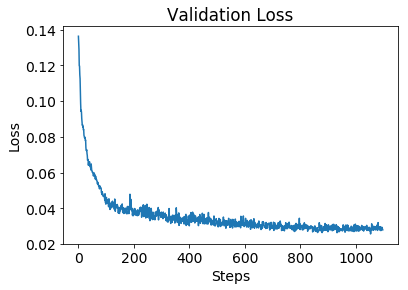

In [225]:
plt.plot(loss_history)
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

In [ ]:
#output = model.forward(image,speed,direction)

### 17. Reshape test camera data

In [45]:
# x_test_camera_2 = np.swapaxes(x_test_camera, 1, 2)
# x_test_camera_2 = np.swapaxes(x_test_camera_2, 1, 3)

### 18. Predict and Plot

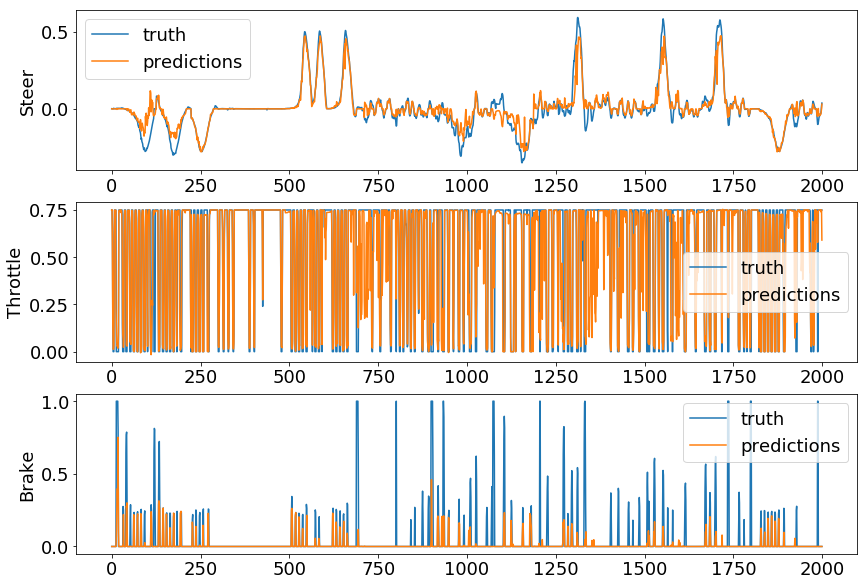

In [226]:
predictions = []
model.eval()
iters = 2000
for i in range(iters):
    image = x_test_camera_2[i].reshape(1, 3, 88, 200)
#     image = torch.from_numpy(image.reshape(1,3,88,200)).type('torch.cuda.FloatTensor')
    image = image.to(device).cuda()

    x_command = x_test_direction_torch[i].reshape(-1,1).cuda()
    x_speed   = x_test_speed_torch[i].reshape(-1,1).cuda()
    # Forward pass
    optimizer.zero_grad()
    output = model(image,x_speed, x_command)
    predictions.append(np.array(output.cpu().detach().numpy())[0])

predictions = np.array(predictions)

fig, ax = plt.subplots(figsize=(14, 10))   
plt.rcParams.update({'font.size': 18})
plt.subplot(3, 1, 1)
plt.plot(np.array(y_test[:,0][0:iters]), label='truth')
plt.plot(predictions[:,0][0:iters], label='predictions')
plt.ylabel('Steer')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(np.array(y_test[:,1][0:iters]), label='truth')
plt.plot(predictions[:,1][0:iters], label='predictions')
plt.ylabel('Throttle')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.array(y_test[:,2][0:iters]), label='truth')
plt.plot(predictions[:,2][0:iters], label='predictions')
plt.ylabel('Brake')
plt.legend()

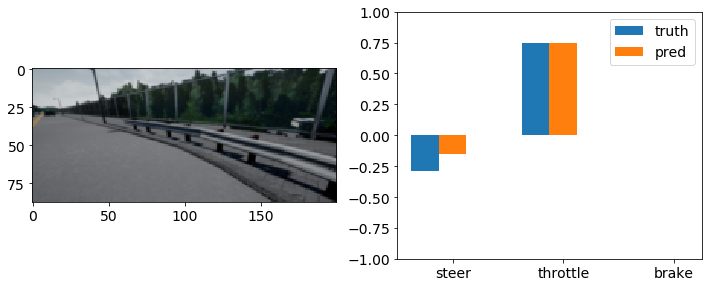

In [223]:
n = np.random.randint(1000)
plt.rcParams.update({'font.size': 14})
image = x_test_camera_2[n:n+1]
speed = x_test_speed_torch[n:n+1].reshape(-1, 1)
direc = x_test_direction_torch[n:n+1].reshape(-1, 1)
image = image.cuda().to(device)
speed = speed.cuda().to(device)
direc = direc.cuda().to(device)
output = model.forward(image, speed, direc)

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

fig, ax = plt.subplots(figsize=(12, 10))   

plt.subplot(2, 2, 1)
plt.imshow(x_test_camera[n])

ax = plt.subplot(2, 2, 2)
truth = y_test[n]
control = output.cpu().detach().numpy()[0]
ind = np.arange(3)
w = 0.25
plt.bar(x=ind, height=[truth[0], truth[1], truth[2]], width=w, label='truth')
plt.bar(x=ind+w, height=[control[0], control[1], control[2]], width=w, label='pred')
plt.ylim([-1, 1])
ax.set_xticks(ind+w)
ax.set_xticklabels( ('steer', 'throttle', 'brake') )
plt.legend()

# plt.autoscale()

### Save Model

In [111]:
PATH='./wustlcarla_torch_v1'
torch.save(model.state_dict(), PATH)